#  <center> <font style="color:rgb(100,109,254)"> Image Colorization </font> </center>
There are deep leaning architectures that can convert a  `Grayscale Image` to a colored image. Imagine taking old Black & white images and converting them to a colored version, how cool is that.


The algorithm that we are going to use today is published by *Zhang et al*. 
Here is the architecture of the network. <br><br>

<center><img src="Media/M4/colorization_arch.PNG"/></center>

The authors took images from ImageNet Dataset and converted all RGB images to the **Lab Color Space**. Basically Lab is also another way to represent colors, we did briefly went over this in our Color Spaces notebook. In this color space just like RGB space we have 3 channels but these are L, a & b channels.  

These are:

  - **L**  L channel encodes lightness intensity
  - **a** In `a` channel green and red colors are encoded.
  - **b** In `b` channel blue and yellow color are encoded.
  
Here L channel holds the actual structure of the image, while other channels holds the color information. Now if we were to convert a grayscale image to a color RGB image then we would've  needed to fill values for 3 different matrices i.e. R,G & B. Now are problem is somewhat easier we only need to guess values for 2 channels i.e. a & b channels.

We can even further simplify this problem by combining a and b channels together into quantized bins of 313. This means for each pixel you would only need to guess between 313 possible values. Otherwise we we had axb (255x255) possible color values.

Now we have reduced our problem to a multi classification problem. Where for each grayscale pixel (*we are going to take L as grayscale channel*) we need to guess the number between 0-312. 

![alt](Media/M4/colorabspace.png)
**Here's the  Complete Process**

- `Convert Grayscale image to Lab color space`
- `Fetch the L channel from Lab color`
- `Give L channel as input to the network and predict the a,b quantized channel `
- `Then combine origianl L channel with predicted ab channels`
- `Lastly convert the Lab image to RGB image.`

The Algorithm we're using is form the paper [Colorful Image Colorization](https://arxiv.org/pdf/1603.08511.pdf ) by **Richard Zhang et al.**


In [61]:
# Import required libraries
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk
import sys
import os

## <font style="color:rgb(134,19,348)"> Initialize DNN Module</font>

In [62]:
# Load the Architecture.
architecture = 'Media/M4/Model/colorization_deploy_v2.prototxt'
# Load the Model Weights.
weights = 'Media/M4/Model/colorization_release_v2.caffemodel'

In [63]:
# Here we are reading colorization model with caffe
net = cv2.dnn.readNetFromCaffe(architecture, weights)
print("Model loaded Succesfully")

Model loaded Succesfully


## <font style="color:rgb(134,19,348)"> Read the Image </font>

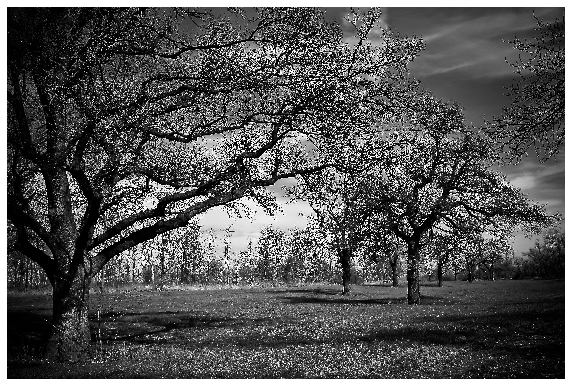

In [64]:
# Load the input image from disk
image = cv2.imread('Media/M4/color2.jpg')

# Display it
plt.figure(figsize=(10,10))
plt.imshow(image[:,:,::-1])
plt.axis("off");

## <font style="color:rgb(134,19,348)"> Load the cluster center points, format it and pass them in the network </font>
These are the a,b quantized bins values, you can think of them as labels of the classifier, the network outputs probabilities for each of these 

In [65]:
points = np.load( 'Media/M4/Model/pts_in_hull.npy')
print(points.shape)

(313, 2)


In [66]:
# Format the points into required shape.
points = points.transpose()
points = points.reshape(2, 313, 1, 1)

print(points.shape)

# Convert to float data type and into a list format.
points_float32 =  [points.astype("float32")]

(2, 313, 1, 1)


In [68]:
# Here we are fetching the required layer IDs 
cls_8 = net.getLayerId("class8_ab")
conv_8 = net.getLayerId("conv8_313_rh")

# Here we are loading cluster ab points into a specific parts of the net.
net.getLayer(cls_8).blobs = points_float32

# This is a scaling layer used for normalization.
net.getLayer(conv_8).blobs =  [np.full([1, 313], 2.606, dtype="float32")]

## <font style="color:rgb(134,19,348)"> Pre-process the Image </font>


In [69]:
# Changing the data type to float32 and divide it 255 so the range should be b/w 0 - 1
scaled_image = image.astype("float32") / 255.0

# Here we are converting the BGR image into the lab color space
lab_image = cv2.cvtColor(scaled_image, cv2.COLOR_BGR2LAB)

# Colorization network requires the image to be in 224x224 
lab_image_resized = cv2.resize(lab_image, (224, 224))

# Fetching the L channel from resized lab color space
l_channel = lab_image_resized[:,:,0] 

# Mean subtraction as this was done by the authors as a preprocessing step.
l_channel -= 50

# Make a blob from the l channel
blob = cv2.dnn.blobFromImage(l_channel)

# set the L channel as input.
net.setInput(blob)

##  <font style="color:rgb(134,19,348)">Forward Pass</font> 


In [71]:
%%time
# Predicted a,b channel 
ab_channel = net.forward()

Wall time: 474 ms


##  <font style="color:rgb(134,19,348)">Post-Processing</font> 
In this step you undo all the steps you did in the pre-processing step

In [72]:
print(ab_channel.shape)

# Reshape the predicted a,b channels
ab_channel_resized = ab_channel[0, :, :, :].transpose((1, 2, 0))
print(ab_channel_resized.shape)

(1, 2, 56, 56)
(56, 56, 2)


In [73]:
# Here we are resizing the predicted a,b channels with simillar dimension of our original image
a_b = cv2.resize(ab_channel_resized, (image.shape[1], image.shape[0]))

print(a_b.shape)

(3072, 4608, 2)


## <font style="color:rgb(134,19,348)"> Merge L & a,b channels </font>


In [74]:
# Here we are fetching L chanel from original image
l_channel = lab_image[:,:,0]
print("shape of L Channel"+str(l_channel.shape))
print("shape of ab Channel"+str(a_b.shape))

shape of L Channel(3072, 4608)
shape of ab Channel(3072, 4608, 2)


In [75]:
# Concatenate both L channel from  original image and ab channel which are predicted
colored = np.concatenate((l_channel[:, :, np.newaxis], a_b), axis=2)
print(colored.shape)

(3072, 4608, 3)


## <font style="color:rgb(134,19,348)">  Convert LAB image back to RGB  </font>

In [76]:
# Convert Lab image to BGR.
colored = cv2.cvtColor(colored, cv2.COLOR_LAB2BGR)

# clip the values below 0 and above 1.
colored = np.clip(colored, 0, 1)

In [77]:
# Multiply by 255 so the range is b/w 0-255 and convert to uint8.
colored = (255 * colored).astype("uint8")

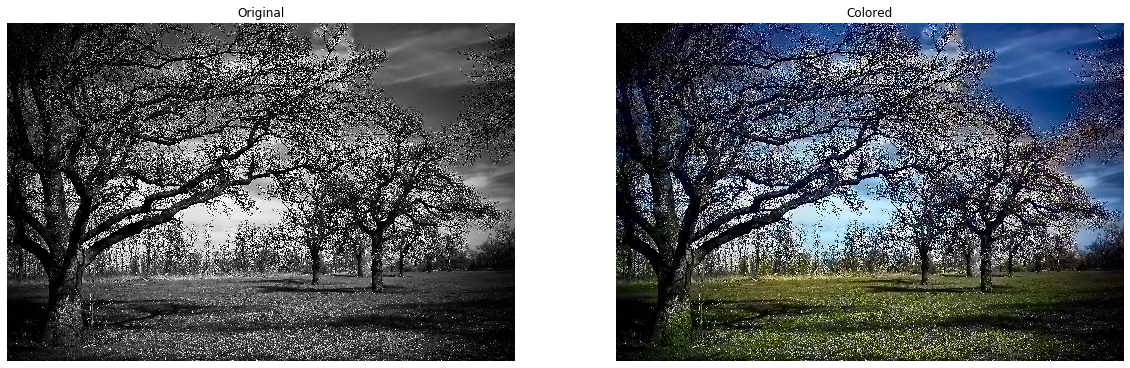

In [78]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1);plt.imshow(image[:,:,::-1]);plt.title("Original");plt.axis("off");
plt.subplot(1,2,2);plt.imshow(colored[:,:,::-1]);plt.title("Colored");plt.axis("off");

## <font style="color:rgb(134,19,348)"> Creating Functions </font> 

## <font style="color:rgb(134,19,348)"> Initialization Function </font>
This method will be run once and it will initialize the network with the required files.

In [79]:
def init_colorized(usegpu = 'None',weights_name = 'colorization_deploy_v2.prototxt',architecture_name ='colorization_release_v2.caffemodel'):
    
    # Set global variables
    global net,points
    
    base_path = 'Media/M4/Model'
    
    protofile = os.path.join(base_path, weights_name);
    model = os.path.join(base_path, architecture_name)
    
    # Load the points
    points_path = os.path.join(base_path,'pts_in_hull.npy')
    points = np.load(points_path)
    
    # Format the points into required shape.
    points = points.transpose()
    points = points.reshape(2, 313, 1, 1)
    
    # Convert to float data type and into a list format.
    points_float32 =  [points.astype("float32")]
    
     # Intialize the model
    net = cv2.dnn.readNetFromCaffe(protofile, model)
    
    # Here we are fetching the required layer IDs 
    cls_8 = net.getLayerId("class8_ab")
    conv_8 = net.getLayerId("conv8_313_rh")

    # Here we are loading cluster ab points into a specific parts of the net.
    net.getLayer(cls_8).blobs = points_float32

    # This is a scaling layer used for normalization.
    net.getLayer(conv_8).blobs =  [np.full([1, 313], 2.606, dtype="float32")]
    
    # If specified use either cuda based Nvidia gpu or opencl based Intel gpu.   
    if usegpu == 'cuda':
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        
    elif usegpu == 'opencl':
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

## <font style="color:rgb(134,19,348)"> Main Method</font>


In [80]:
def colorization(image=[],returndata=False):
    
    # If the user did'nt specified the image then consider then consider choosing file or camera snapshot.
    if np.size(image) == 0:
        
         # Ohterwise Select image from computer using tkinter
        root = Tk()
        root.filename =  filedialog.askopenfilename(title = "Pick up the Image")
        root.withdraw()
        image = cv2.imread(root.filename)
        
    
    # Changing the data type to float32 and divide it 255 so the range should be b/w 0 - 1
    scaled_image = image.astype("float32") / 255.0

    # Here we are converting the BGR image into the lab color space
    lab_image = cv2.cvtColor(scaled_image, cv2.COLOR_BGR2LAB)

    # Colorization network requires the image to be in 224x224 
    lab_image_resized = cv2.resize(lab_image, (224, 224))

    # Fetching the L channel from resized lab color space
    l_channel = lab_image_resized[:,:,0] 

    # Mean subtraction as this was done by the authors as a preprocessing step.
    l_channel -= 50

    # Make a blob from the l channel
    blob = cv2.dnn.blobFromImage(l_channel)

    # set the L channel as input.
    net.setInput(blob)

    # Predicted a,b channel 
    ab_channel = net.forward()

    # Reshape the predicted a,b channels
    ab_channel_resized = ab_channel[0, :, :, :].transpose((1, 2, 0))

    # Here we are resizing the predicted a,b channels with simillar dimension of our original image
    a_b = cv2.resize(ab_channel_resized, (image.shape[1], image.shape[0]))

    # Here we are fetching L chanel from original image
    l_channel = lab_image[:,:,0]

    # Concatenate both L channel from  original image and ab channel which are predicted
    colored = np.concatenate((l_channel[:, :, np.newaxis], a_b), axis=2)

    # Convert Lab image to BGR.
    colored = cv2.cvtColor(colored, cv2.COLOR_LAB2BGR)

    # clip the values below 0 and above 1.
    colored = np.clip(colored, 0, 1)

    # Multiply by 255 so the range is b/w 0-255 and convert to uint8.
    colored = (255 * colored).astype("uint8")

    
    if  returndata:
        return colored
    else:
        plt.figure(figsize=(20,20))
        plt.subplot(1,2,1);plt.imshow(image[:,:,::-1]);plt.title("Original");plt.axis("off");
        plt.subplot(1,2,2);plt.imshow(colored[:,:,::-1]);plt.title("Colored");plt.axis("off");

**Initialize the Colorization**

In [81]:
init_colorized()

**Calling Colorization with default arguments.**

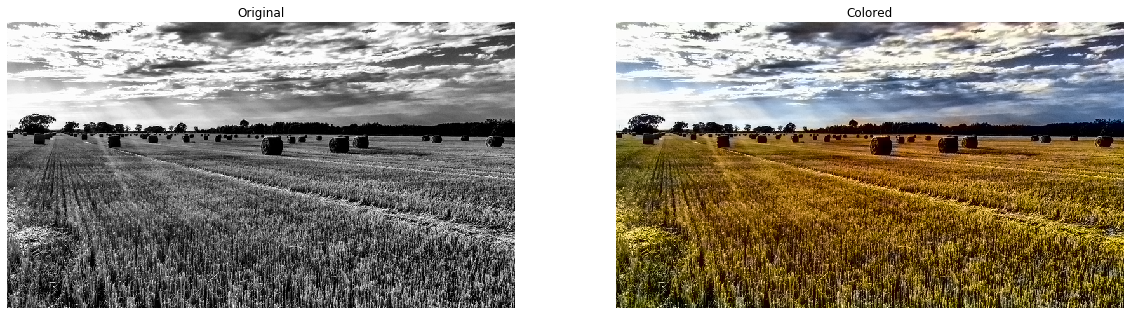

In [82]:
image = cv2.imread('Media/M4/color1.jpg')
colorization(image)

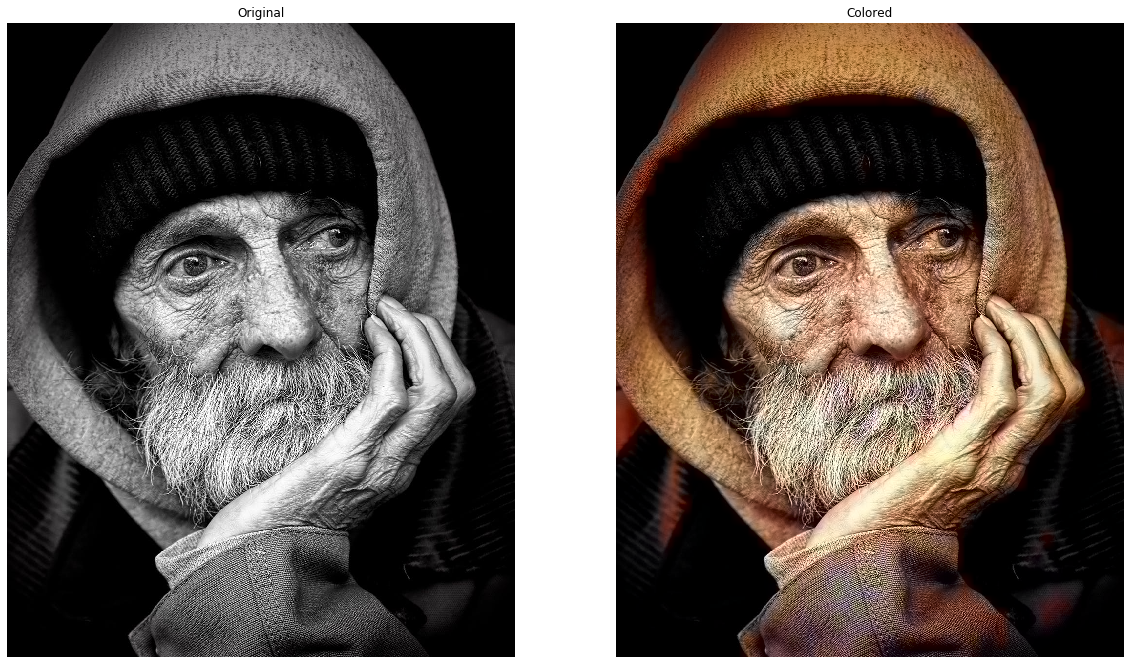

In [83]:
image = cv2.imread('Media/M4/oldman.jpg')
colorization(image)

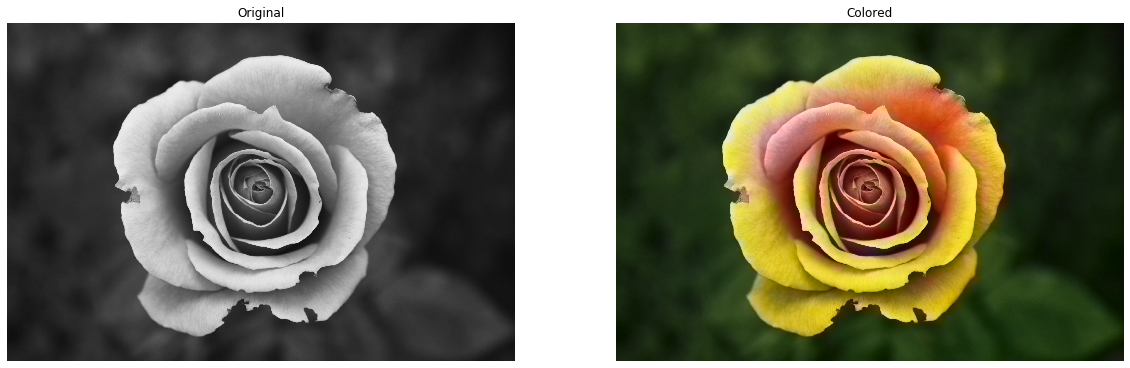

In [84]:
image = cv2.imread('Media/M4/color3.jpg')
colorization(image)

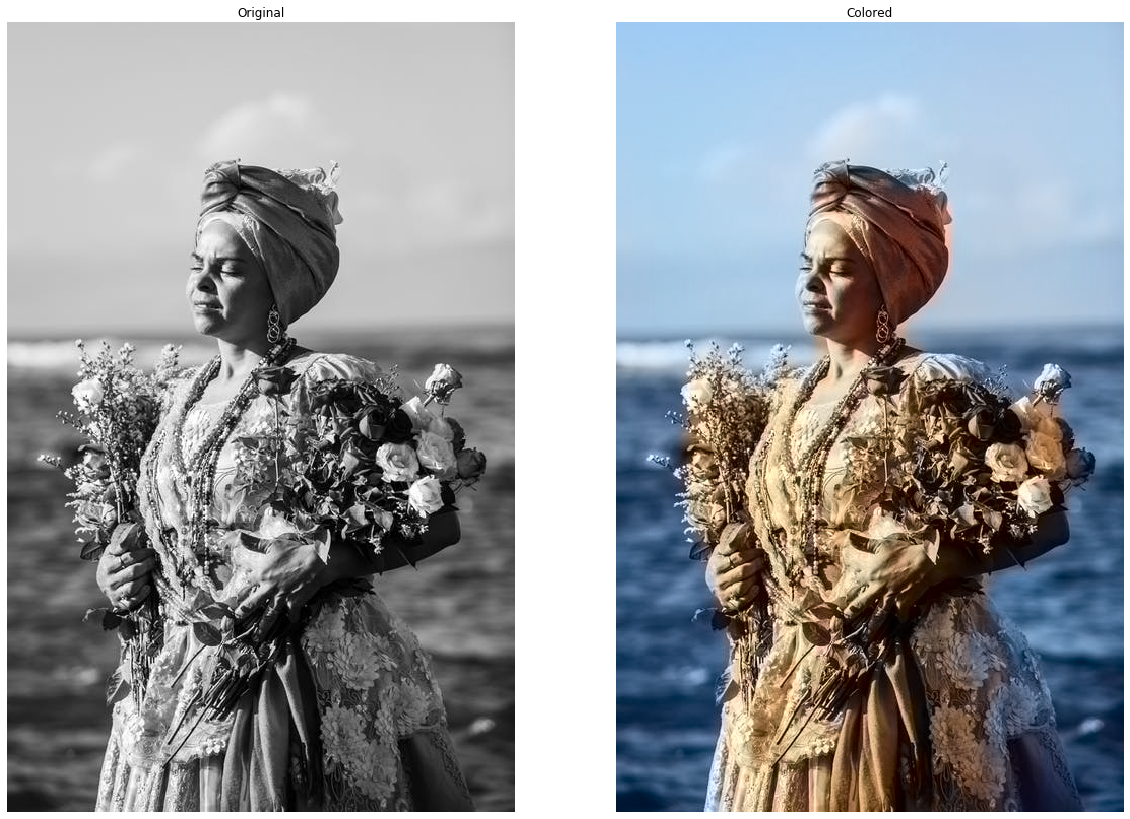

In [85]:
image = cv2.imread('Media/M4/color4.jpeg')
colorization(image)

## <font style="color:rgb(134,19,348)"> Using Intel & Nvidia GPUs </font>

**CPU Time**

In [ ]:
init_colorized()

In [ ]:
%%time
image= colorization(image = image, returndata=True)

**Intel GPU**

In [ ]:
init_colorized(usegpu = 'opencl')

In [ ]:
%%time
image= colorization(image = image, returndata=True)

**NVIDIA GPU**

In [ ]:
init_colorized(usegpu = 'cuda')

In [ ]:
%%time
image= colorization(image = image, returndata=True)

## <font style="color:rgb(134,19,348)">  Video Colorization</font>

In [ ]:
# Initializing method
init_colorized()

# Starting video reading mode
cap = cv2.VideoCapture('Media/M4/oldy.mp4')
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Specifying Video writing path
out = cv2.VideoWriter(r'Media/M4/colorized.mp4',fourcc, 20.0, (700,500))

while(True):
    
    ret, frame = cap.read()
    if not ret:
        break
        
    frame = colorization(frame,returndata=True)
    
    cv2.imshow('Orignal VS Colorized Frame',frame)
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    #print(final.shape)
cap.release()
out.release()
cv2.destroyAllWindows()